## Note:

All images and full animations are available on my public github: https://github.com/KasiaMacioszek/AgentBasedModelling

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt, animation
from PIL import Image
from matplotlib.colors import ListedColormap

In [134]:
class BurningForest():
    # 0 - empty, 1 - occupied, -1 - burning, 2 - burned
    # windStrength in [0, 1]

    def __init__(self, L, wind=False, windStrength=0):
        self.L = L
        self.forest = np.zeros((L, L))
        
        self.windDirection = wind
        self.windStrength = windStrength
        
        self.allLabels = np.arange(L*L)
    
    def initiateForest(self, p):
        self.forest = np.zeros((self.L, self.L))
        for i in range(self.L):
            for j in range(self.L):
                if np.random.uniform() < p:
                    self.forest[i, j] = 1
                    
    def initiateFire(self):
        for i in range(self.L):
            state = self.forest[i, 0]
            if state == 1:
                self.forest[i, 0] = -1
                
    def getNeighbors(self, pos):
        i = pos[0]
        j = pos[1]
        neighbors = [(i-1, j-1), (i-1, j), (i+1, j), (i, j+1), (i, j-1), (i-1, j+1), (i+1, j-1), (i+1, j+1)]
        cleaned_neighbors = [(x, y) for x, y in neighbors if (x >= 0 and x < self.L and y >= 0 and y < self.L)]
        return cleaned_neighbors
    
    def performBurning(self, numberOfSimulations=100, wind=False):
        ps = np.arange(0.01, 1, 0.01)
        res = np.zeros(len(ps))
        for p in range(len(ps)):
            for i in range(numberOfSimulations):
                self.initiateForest(ps[p])
                if (not wind): 
                    res[p] += self.simulateFire()
                else:
                    res[p] += self.simulateFireWithWind()
            res[p] /= numberOfSimulations
        return res
    
    def simulateFire(self):
        self.initiateFire()
        fireOngoing = True
        while fireOngoing:
            self.burning = list(zip(*np.where(self.forest == -1)))
            if len(self.burning) == 0:
                return 0
            for tree in self.burning:
                neighbors = self.getNeighbors(tree)
                for neighbor in neighbors:
                    i, j = neighbor
                    if j >= self.L-1:
                        return 1
                    if self.forest[i, j] == 1:
                        self.forest[i, j] = -1
                self.forest[tree[0], tree[1]] = 2
        return 0
    
    def simulateFireWithResultsSave(self):
        self.initiateFire()
        
        fireStates = self.forest
        fireOngoing = True
        while fireOngoing:
            fireStates = np.vstack([fireStates, self.forest])
            self.burning = list(zip(*np.where(self.forest == -1)))
            if len(self.burning) == 0:
                return fireStates
            for tree in self.burning:
                neighbors = self.getNeighbors(tree)
                for neighbor in neighbors:
                    i, j = neighbor
                    if j >= self.L-1:
                        return fireStates
                    if self.forest[i, j] == 1:
                        self.forest[i, j] = -1
                self.forest[tree[0], tree[1]] = 0
        fireStates = np.vstack([fireStates, self.forest])
        return fireStates
    
    def getNeighborsForHK(self, pos):
        i = pos[0]
        j = pos[1]
        allNeighbors = self.get_neighbors(pos)
        HKNeighbors = [neighbor for neighbor in allNeighbors if (neighbor[1] != j+1) and neighbor != (i+1, j)]
        return HKNeighbors
    
    def find(self, label):
        labelCopy = label

        while self.allLabels[labelCopy] != labelCopy:
            labelCopy = self.allLabels[labelCopy]   
        while self.allLabels[label] != label:
            newLabel = self.allLabels[label]
            self.allLabels[label] = labelCopy
            label = newLabel       
        return labelCopy

    def union(self, label1, label2):
        self.allLabels[self.find(label1)] = self.find(label2)    

    def hoshen_kopelman(self): 
        largestLabel = 0
        labels = np.zeros((self.L, self.L), dtype=int)
        for col in range(self.L):
            for row in range(self.L):  
                if self.forest[row, col] == 2:
                    neighbors = self.getNeighborsForHK((row, col))
                    neighborLabels = [labels[pos[0], pos[1]] for pos in neighbors if labels[pos[0], pos[1]] != 0]

                    if len(neighborLabels) != 0:
                        min_label = min(neighborLabels)
                        labels[row, col] = min_label
                        for label in neighborLabels:
                            if label != min_label:
                                self.union(label, min_label) 
                    else:
                        largestLabel += 1
                        labels[row, col] = largestLabel
        nums, counts = np.unique(labels, return_counts=True)
        clusters = dict(zip(nums, counts))

        if 0 in clusters:
            clusters.pop(0)
        if len(clusters) == 0:
            return 0
        return max(clusters.values())

In [130]:
def animateFire(data, gif_name="anim"):
    fig = plt.figure()
    sns.heatmap(data[0], vmax=.8, square=True, cbar=False, cmap=ListedColormap(['red', 'black', 'green']), yticklabels=False, xticklabels=False)

    def init():
        sns.heatmap(data[0], vmax=.8, square=True, cbar=False, cmap=ListedColormap(['red', 'black', 'green']), yticklabels=False, xticklabels=False)

    def animate(i):
        sns.heatmap(data[i], vmax=.8, square=True, cbar=False, cmap=ListedColormap(['red', 'black', 'green']), yticklabels=False, xticklabels=False)

    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(data), repeat = False)
    anim.save(f'images/{gif_name}.gif')

In [131]:
def clean_results(res, L):
    new_res = list(np.zeros(int(len(res)/L-1)))
    for i in range(len(new_res)):
        new_res[i] = res[int((i+1)*L): int((i+2)*L)]
    return new_res

## Animations

In [58]:
ps = [0.3, 0.5, 0.7, 0.99]
animNames = ["anim03", "anim05", "anim07", "anim099"]

MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


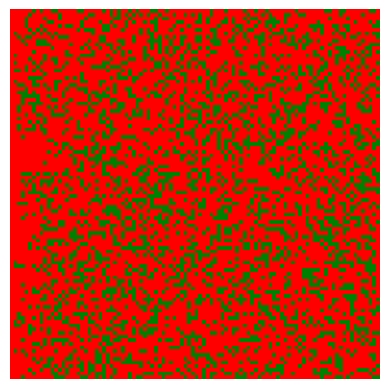

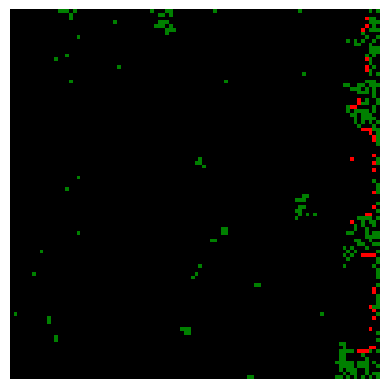

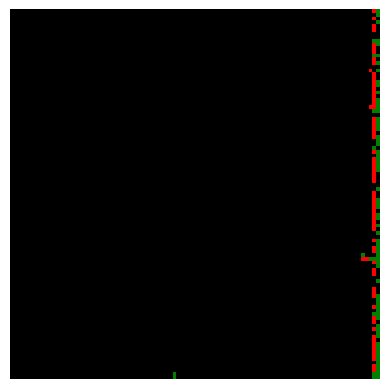

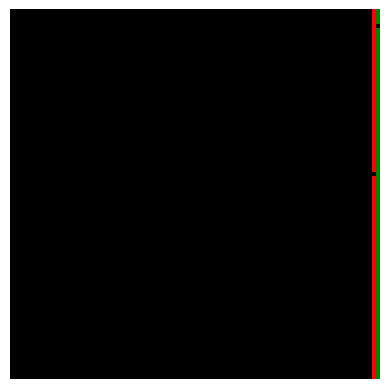

In [59]:
for i, p in enumerate(ps):
    BF = BurningForest(100)
    BF.initiateForest(p)
    result = BF.simulateFireWithResultsSave()
    cleanResult = clean_results(result, 100)
    animateFire(cleanResult, animNames[i])

## Percolation threshold

In [22]:
Ls = [20, 50, 100]
percolationThreshold = list(np.zeros(len(Ls)))
ps = np.arange(0.01, 1, 0.01)
N = 100
markers = ['D', '*', 'o']

In [61]:
ps = np.arange(0.01, 1, 0.01)

In [23]:
for i in range(len(Ls)):
    BF = BurningForest(Ls[i])
    percolationThreshold[i] = BF.performBurning(N)

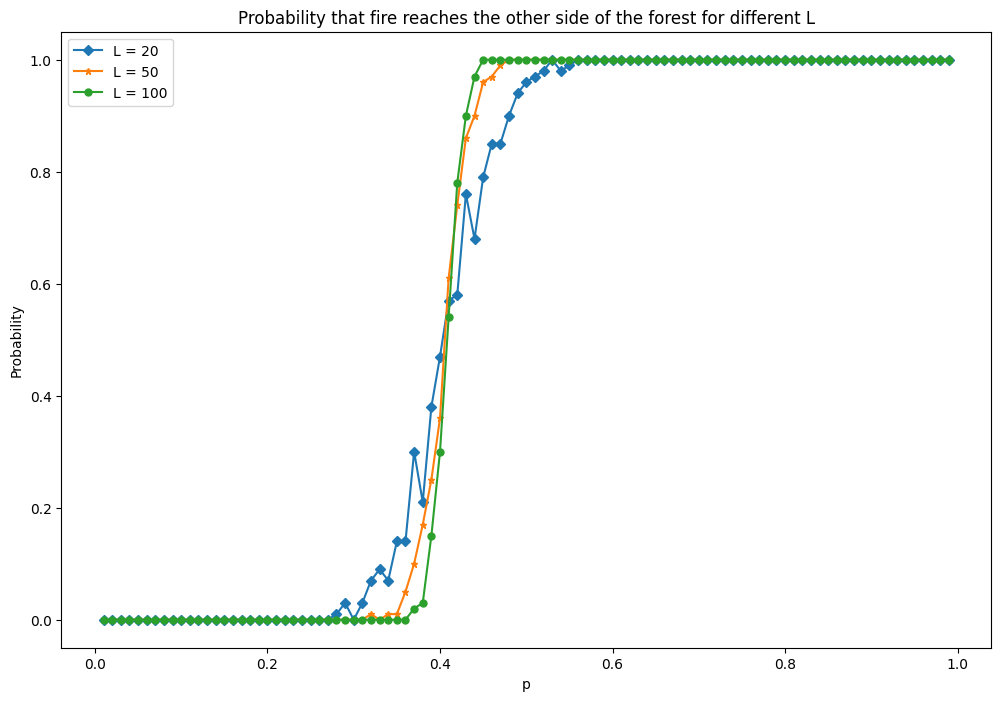

In [62]:
plt.figure(figsize=(12, 8))
for i in range(len(Ls)):
    plt.plot(ps, percolationThreshold[i], label=f"L = {Ls[i]}", marker=markers[i], markersize=5)
plt.legend()
plt.title("Probability that fire reaches the other side of the forest for different L")
plt.xlabel("p")
plt.ylabel("Probability")
plt.savefig('images/percolationThreshold2.png')

## Average biggest cluster 

In [33]:
N = 100
ps = np.arange(0.01, 1, 0.01)
biggestCluster = np.zeros(len(ps))

In [34]:
for i, p in enumerate(ps):
    for j in range(N):
        BF = BurningForest(100)
        BF.initiateForest(p)
        BF.simulateFire()
            
        biggestCluster[i] += BF.hoshen_kopelman()
        
    biggestCluster[i] /= N

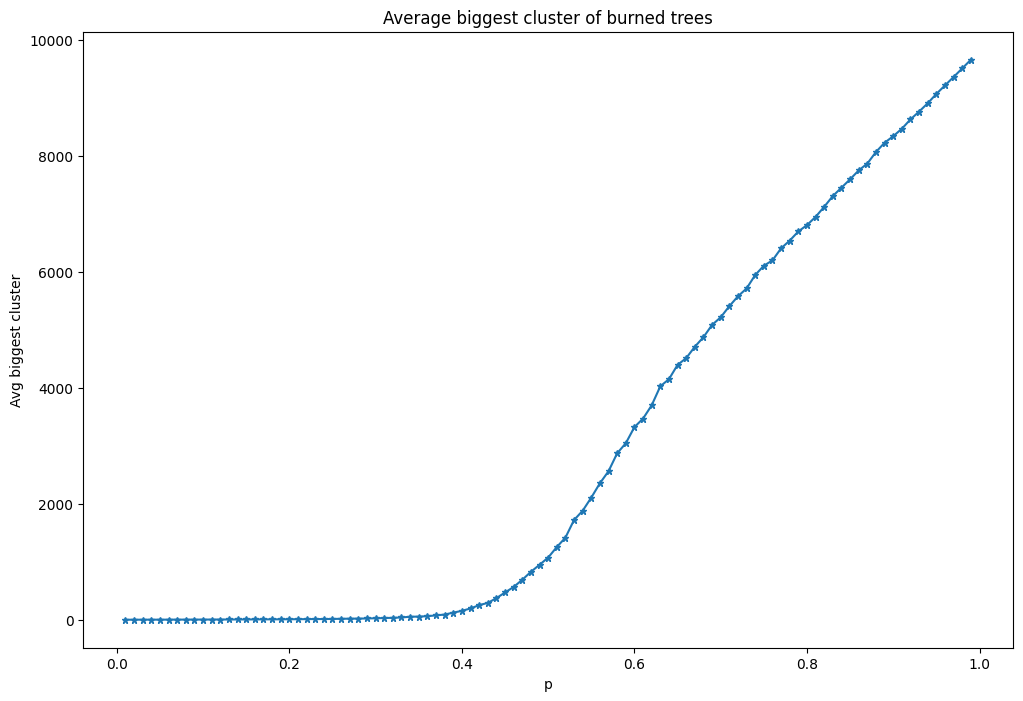

In [64]:
plt.figure(figsize=(12, 8))
plt.plot(ps, biggestCluster, marker='*', markersize=5)
plt.xlabel("p")
plt.title("Average biggest cluster of burned trees")
plt.ylabel("Avg biggest cluster")
plt.savefig('images/avgBiggestCluster.png')